In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
dataset_path = os.listdir('/home/adhil/Documents/RIP competition Data/r2+1d/R(2+1)D_Training_Features/frontal_view')
print(f'label types: {dataset_path}')

label types: ['Left Turn', 'Slow-Stop', 'Left Lane Change', 'Right Turn', 'Right Lane Change', 'Straight']


In [3]:
train = '/home/adhil/Documents/RIP competition Data/r2+1d/R(2+1)D_Training_Features/frontal_view'
val = '/home/adhil/Documents/RIP competition Data/r2+1d/r2+1d_val_features/frontal_view'

def prepare_data(data_path):

    rooms = []
    tags = os.listdir(data_path)

    for item in tags:
        all_rooms = os.listdir(data_path + '/' +item)

        for room in all_rooms:
            rooms.append((item, data_path + '/' +item + '/' + room))

    final_data = pd.DataFrame(data=rooms, columns=['tag', 'video_name'])
    label_mapping = {
    'Straight': 0,
    'Left Lane Change': 1,
    'Right Lane Change': 2,
    'Left Turn': 3,
    'Right Turn': 4,
    'Slow-Stop': 5
    }

    final_data['label'] = final_data['tag'].map(label_mapping)
    final_data = final_data.loc[:, ['video_name', 'label']]
    return final_data

In [4]:
train_df = prepare_data(train)
val_df = prepare_data(val)

print(f"Train {train_df.shape}, Validation {val_df.shape}")

Train (500, 2), Validation (200, 2)


 Min no. of frames is : 1 & Max is: 33 



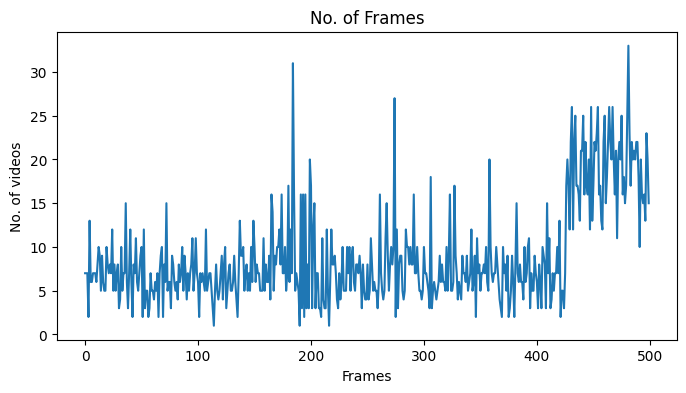

 Min no. of frames is : 1 & Max is: 35 



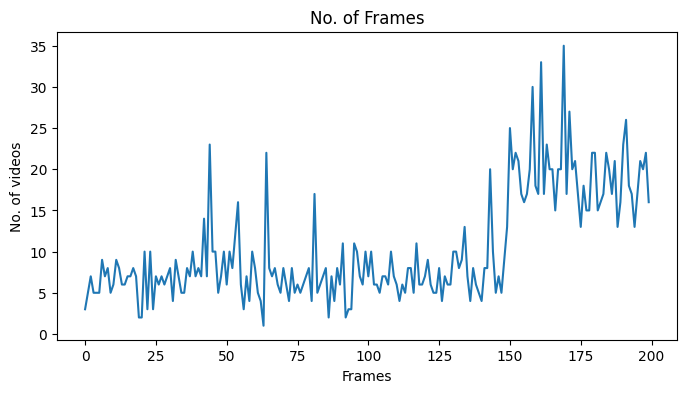

In [5]:
def frames_viz():
  for data in [train_df, val_df]:
    features = data.iloc[:, 0]
    all_features = [np.load(f) for f in features]
    lengths = [len(f) for f in all_features]
    print(f' Min no. of frames is : {min(lengths)} & Max is: {max(lengths)} \n')
# num_classes, num_features = 6, 512

    plt.figure(figsize=(8, 4))
    plt.title(f'No. of Frames')
    plt.plot(lengths)
    plt.xlabel('Frames')
    plt.ylabel('No. of videos')
    plt.show()

frames_viz()

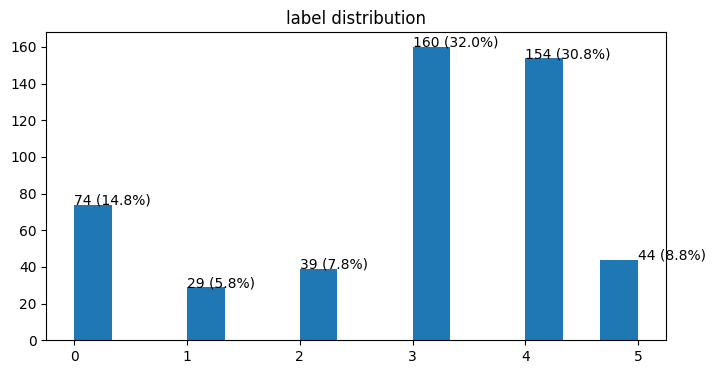

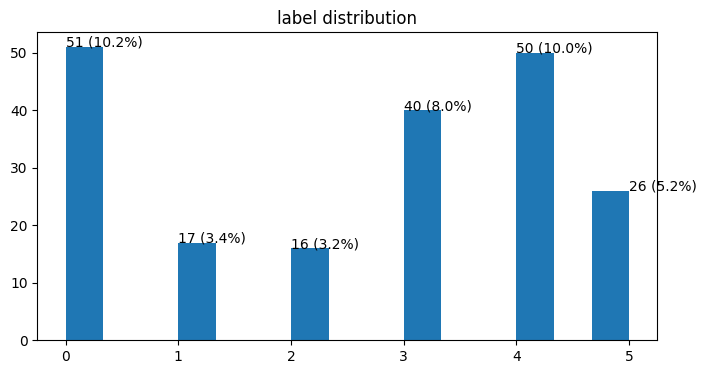

In [6]:
def labels_viz():
    for data in [train_df, val_df]:
      for i in data.label:
        data.value_counts()

      plt.figure(figsize=(8, 4))
      plt.title('label distribution')
      plt.hist(data.label, bins=15)
      for tag, count in data.label.value_counts().items():
          plt.text(tag, count, str(count)+' ('+str(round((count/500)*100, 2))+'%)')
      plt.show()

labels_viz()

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, f1_score
import torch.nn.functional as F

In [6]:
# class RipDataset:
#     def __init__(self, data):
#         self.data = data
#         self.scaler = MinMaxScaler()

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         video_name = self.data.iloc[idx, 0]
#         label = self.data.iloc[idx, 1]
#         video_features = np.load(video_name)
#         video_features = self.scaler.fit_transform(video_features)

#         return torch.tensor(video_features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# # Pad the sequences in the batch
# def collate_fn(batch):
#     features = [item[0] for item in batch]
#     labels = [item[1] for item in batch]
#     padded_features = pad_sequence(features, batch_first=True, padding_value=0)
#     return padded_features, torch.stack(labels)

In [7]:
class RipDataset(Dataset):
    def __init__(self, data, max_length=None):
        self.data = data
        self.features = self.data.iloc[:, 0]
        self.labels = data.iloc[:, 1]
        self.max_length = max_length
        self.scaler = StandardScaler()

        all_features = [np.load(f) for f in self.features]

        if max_length is None:
            lengths = [len(f) for f in all_features]
            self.max_length = int(np.percentile(lengths, 90))

        # Flatten features for scaling
        flat_features = np.vstack(all_features)
        self.scaler.fit(flat_features)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        feature_path = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]

        feature = np.load(feature_path)
        feature = self.scaler.transform(feature)

        # Pad or truncate
        if len(feature) > self.max_length:
            feature = feature[:self.max_length]
        elif len(feature) < self.max_length:
            pad_length = self.max_length - len(feature)
            feature = np.pad(feature, ((0, pad_length), (0, 0)), mode='constant')

        return torch.FloatTensor(feature), torch.LongTensor([label])

def collate_fn(batch):
    features, labels = zip(*batch)
    features = pad_sequence(features, batch_first=True, padding_value=0)
    labels = torch.cat(labels)
    return features, labels

In [8]:
train_dataset = RipDataset(train_df)
val_dataset = RipDataset(val_df)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

print(f"Total No. of Batches: {len(train_dataloader)} \n")
print("=" * 50)
for _, (features, labels) in enumerate(train_dataloader):
    print(f' \n Batch No: {_+1}, \n Data shape {features.shape} \n Labels {labels.shape}')
    print("=" * 50)
    if _ == 2:
        break

Total No. of Batches: 4 

 
 Batch No: 1, 
 Data shape torch.Size([128, 17, 512]) 
 Labels torch.Size([128])
 
 Batch No: 2, 
 Data shape torch.Size([128, 17, 512]) 
 Labels torch.Size([128])
 
 Batch No: 3, 
 Data shape torch.Size([128, 17, 512]) 
 Labels torch.Size([128])


In [104]:
class CRNN(nn.Module):
    def __init__(self, in_channels, out_channels, n_classes, verbose=False):
        super(CRNN, self).__init__()
        
        self.n_classes = n_classes
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.verbose = verbose

        self.cnn = nn.Conv1d(in_channels=self.in_channels, 
                             out_channels=self.out_channels, 
                             kernel_size=1, 
                             stride=1,
                             padding=1)
        
        self.rnn = nn.LSTM(input_size=self.out_channels, 
                           hidden_size=self.out_channels, 
                           num_layers=1, 
                           batch_first=True, 
                           bidirectional=False)
        
        self.dense = nn.Linear(out_channels, n_classes)

        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        if self.verbose:
            x = x.permute(0, 2, 1)  # (batch, seq_len, in_channels)  -->  (batch, in_channels, seq_len)
        if self.verbose:
            x = self.cnn(x)
            x = self.dropout(x) 
        if self.verbose:
            x = x.permute(0, 2, 1)  # (batch, seq_len, out_channels)
        if self.verbose:
            _, (x, _) = self.rnn(x)
            x = x.squeeze(0)  
        if self.verbose:
            x = self.dropout(x) # 0.5 dropout
            x = self.dense(x)

        return self.softmax(x)

# Create the model
in_channels = 512  
out_channels = 16
n_classes = 6  

model = CRNN(in_channels=in_channels, out_channels=out_channels, n_classes=n_classes, verbose=True)

In [105]:
# Hyperparameters
EPOCHS = 500
LEARNING_RATE = 0.001
# WEIGHT_DECAY = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Focal Loss
criterion = torch.hub.load(
	'adeelh/pytorch-multi-class-focal-loss',
	model='FocalLoss',
	gamma=2,
	reduction='mean',
	force_reload=False
)
# 	alpha=torch.tensor([.75, .25]),

Using cache found in /home/adhil/.cache/torch/hub/adeelh_pytorch-multi-class-focal-loss_master


In [106]:
def custom_accuracy(outputs, labels):
    n = labels.size(0)
    probabilities = F.softmax(outputs, dim=1)
    correct = 0
    for i in range(n):
        if torch.argmax(probabilities[i]) == labels[i]:
            correct += probabilities[i][labels[i]]
    return correct / n

In [110]:
def training_loop(model, train_loader, val_loader, num_epochs, patience_limit=50):
    train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list, val_f1_list = [], [], [], [], []
    best_val_accuracy = 0
    best_val_f1 = 0
    best_model_state = None
    best_val_predictions = None
    patience_counter = 0

    for epoch in range(1, num_epochs+1):
        model.train()
        train_loss, train_accuracy = 0, 0
        for batch in train_loader:
            inputs, labels = batch
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_accuracy += custom_accuracy(outputs, labels) * inputs.size(0)

        model.eval()
        val_loss, val_accuracy = 0, 0
        val_predictions, val_true_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_accuracy += custom_accuracy(outputs, labels) * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_predictions.extend(predicted.cpu().numpy())
                val_true_labels.extend(labels.cpu().numpy())

        # Calculate average losses and accuracies
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)
        avg_train_accuracy = (train_accuracy / len(train_loader.dataset)) * 100
        avg_val_accuracy = (val_accuracy / len(val_loader.dataset)) * 100
        val_f1 = f1_score(val_true_labels, val_predictions, average='weighted') * 100

        # Append to lists for plotting
        train_loss_list.append(avg_train_loss)
        val_loss_list.append(avg_val_loss)
        train_accuracy_list.append(avg_train_accuracy)
        val_accuracy_list.append(avg_val_accuracy)
        val_f1_list.append(val_f1)

        scheduler.step(avg_val_loss)

        print(
            f"Epoch [{epoch}/{num_epochs}], "
            f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
            f"Train Accuracy: {avg_train_accuracy:.2f}%, Val Accuracy: {avg_val_accuracy:.2f}%, "
            f"Val F1 Score: {val_f1:.2f}%"
        )

        # Check if this is the best model so far
        if avg_val_accuracy > best_val_accuracy or (avg_val_accuracy == best_val_accuracy and val_f1 > best_val_f1):
            best_val_accuracy = avg_val_accuracy
            best_val_f1 = val_f1
            best_model_state = model.state_dict()
            best_val_predictions = val_predictions
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience_limit:
            print(f"\nEarly stopping at epoch {epoch} due to no improvement in val accuracy for {patience_limit} epochs.")
            break

    # Load the best model state
    model.load_state_dict(best_model_state)

    return (model, train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list, 
            val_f1_list, best_val_predictions, best_val_accuracy, best_val_f1, val_predictions)

# Start training
(trained_model, train_losses, val_losses, train_accuracies, val_accuracies, 
 val_f1_scores, best_val_predictions, best_val_accuracy, best_val_f1, val_predictions) = training_loop(model, train_dataloader, val_dataloader, EPOCHS)

# Print the best performance achieved
print(f"Best Accuracy (%): {best_val_accuracy:.2f}")
print(f"Best F1 score (%): {best_val_f1:.2f}")

Epoch [1/500], Train Loss: 0.9256, Val Loss: 0.9970, Train Accuracy: 14.21%, Val Accuracy: 11.27%, Val F1 Score: 36.25%
Epoch [2/500], Train Loss: 0.9186, Val Loss: 0.9970, Train Accuracy: 14.50%, Val Accuracy: 11.27%, Val F1 Score: 36.25%
Epoch [3/500], Train Loss: 0.9211, Val Loss: 0.9970, Train Accuracy: 14.98%, Val Accuracy: 11.27%, Val F1 Score: 36.25%
Epoch [4/500], Train Loss: 0.9283, Val Loss: 0.9970, Train Accuracy: 13.97%, Val Accuracy: 11.27%, Val F1 Score: 36.25%
Epoch [5/500], Train Loss: 0.9223, Val Loss: 0.9970, Train Accuracy: 14.70%, Val Accuracy: 11.27%, Val F1 Score: 36.25%
Epoch [6/500], Train Loss: 0.9279, Val Loss: 0.9970, Train Accuracy: 13.73%, Val Accuracy: 11.27%, Val F1 Score: 36.25%
Epoch [7/500], Train Loss: 0.9230, Val Loss: 0.9970, Train Accuracy: 14.15%, Val Accuracy: 11.27%, Val F1 Score: 36.25%
Epoch [8/500], Train Loss: 0.9290, Val Loss: 0.9969, Train Accuracy: 13.49%, Val Accuracy: 11.27%, Val F1 Score: 36.25%
Epoch [9/500], Train Loss: 0.9244, Val L

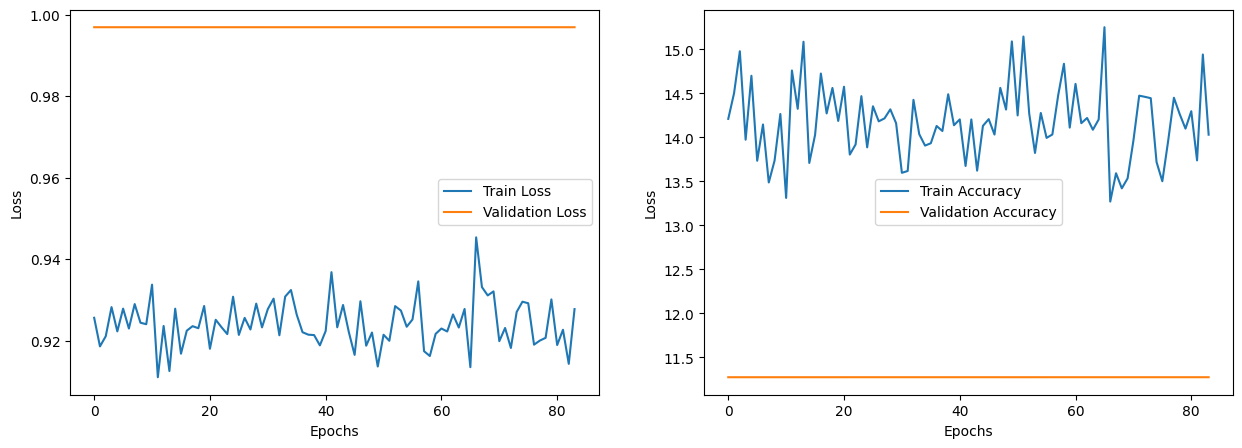

In [111]:
def viz():
  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot([acc.detach().numpy() for acc in train_accuracies], label='Train Accuracy')
  plt.plot([acc.detach().numpy() for acc in val_accuracies], label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

viz()

## Evaluation (Accuracy & Precision)

In [112]:
action_labels = ['Left Lane Change', 'Left Turn', 'Right Lane Change', 'Right Turn', 'Slow-Stop', 'Straight']

def get_filename(full_path):
    return os.path.splitext(os.path.basename(full_path))[0]

video_names = [get_filename(path) for path in val_dataset.data['video_name']]

predictions_df = pd.DataFrame({
    'frontal_view_video_name': video_names
})

# Add columns for each action, initialized with zeros
for action in action_labels:
    predictions_df[action] = 0

# Set the predicted action to 1 for each video
for i, pred in enumerate(val_predictions):
    action = action_labels[pred]
    predictions_df.loc[i, action] = 1

predictions_df.to_csv('validation_predictions.csv', index=False)
print("Validation predictions saved to 'validation_predictions.csv'")

Validation predictions saved to 'validation_predictions.csv'
